In [1]:
from utils import (PaintingsDataset, Unet_Discriminator, Unet_Generator, generate_CutMix_samples,
                    mix, rand_bbox, loss_decoder, loss_encoder, loss_regularization)
import random
import torch
from torchmetrics.image.fid import FrechetInceptionDistance
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm.notebook import tqdm
import time

In [2]:
np.__version__

'1.26.4'

In [2]:
# Building the dataset
image_dir = '../../data/resized/resized/'


# Transformations to normalize the data and prepare it for dataloader
transform = transforms.Compose([
    transforms.Resize((128,128)), # Standardizing the size of the images
    transforms.ToTensor(), # Transforming to tensor
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) # Normalizing
])


# Dataset 
paintings = PaintingsDataset(image_dir, transform)

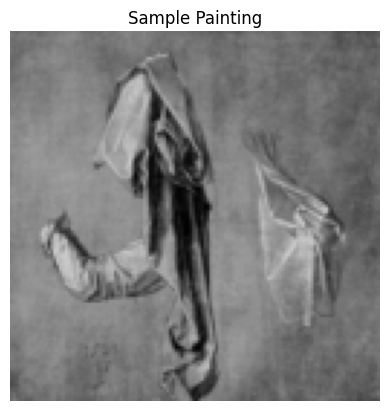

In [3]:
# Plotting an example from  the dataset
n = len(paintings)
integer = random.randint(0,n)

real_image = paintings[integer]
image = real_image.numpy()*0.5 + 0.5

# Plot the image
plt.imshow(np.transpose(image, (1, 2, 0)))  
plt.axis('off')  # Hide axes
plt.title('Sample Painting')
plt.show()


<strong> Defining the dataloader </strong>

In [8]:
dataloader = DataLoader(paintings, batch_size=4)

<strong> Defining the models </strong>

In [4]:
# Defining the parameters of the input and the ouput
input_channels = 3
output_channels = 16
latent_dim = 40
channels_out = 3

# Defining the models
D_unet = Unet_Discriminator(input_channels, output_channels)
G_unet = Unet_Generator(latent_dim, channels_out)

<strong> Plotting the cutmixed image</strong>

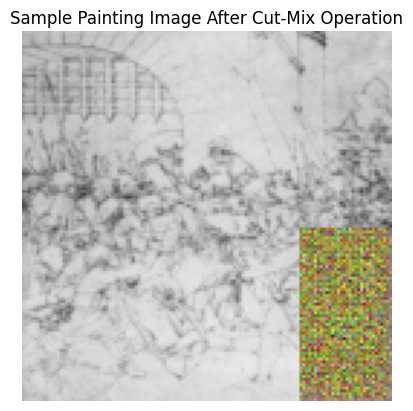

In [6]:
# Selecting randomly a sample from the dataset to plot the examples
integer = random.randint(0, n)
image = paintings[integer]

# Generate random noise
noise = torch.randn(1, latent_dim, 128, 128)  # Batch of 16 noise vectors

# Generate images
fake_images = G_unet(noise)

# Generating another example from the dataset
integer = random.randint(0,n)
real_image = paintings[integer]

# Unsqueezing to match the shape of input
real_image = real_image.unsqueeze(0)

# Generating the cutmix image
ratio, cutmixed, cutmixed_decoded, target_a, target_b, bbx1, bbx2, bby1, bby2 = generate_CutMix_samples(real_image, fake_images, D_unet)

# Preprocessing to de-normalize
cut_mixed = cutmixed.squeeze(0).detach().numpy()*0.5 +0.5

# Plot the image
plt.imshow(np.transpose(cut_mixed, (1, 2, 0)))  
plt.axis('off')  # Hide axes
plt.title('Sample Painting Image After Cut-Mix Operation')
plt.show()

<strong> Plotting the two true images before mixing</strong>

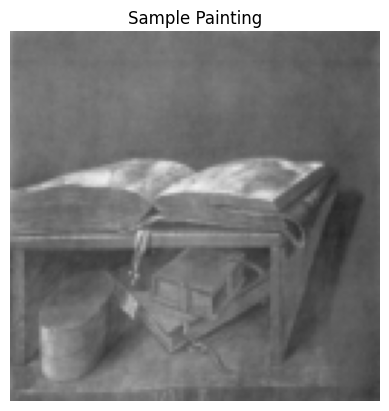

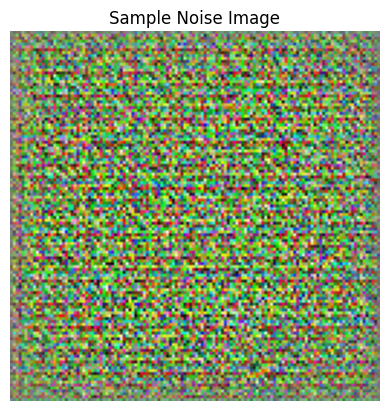

In [11]:
image_1, image_2 = target_a.squeeze(0).detach().numpy(), target_b.squeeze(0).detach().numpy()
image_1, image_2 = 0.5 * image_1 + 0.5, 0.5 * image_2 + 0.5


# Plot the image
plt.imshow(np.transpose(image_1, (1, 2, 0)))  
plt.axis('off')  # Hide axes
plt.title('Sample Painting')
plt.show()

# Plot the image
plt.imshow(np.transpose(image_2, (1, 2, 0)))  
plt.axis('off')  # Hide axes
plt.title('Sample Noise Image')
plt.show()

<strong> Let build the training loop</strong>

In [ ]:
torch.autograd.set_detect_anomaly(True)

# Parameters
input_channels = 3
n_classes = 2
k = 5  # Steps to train generator
latent_dim = 40


epochs = 1000  # Total number of epochs
p_mix = 0 # Probability of generating the cutmix images
steps_mix = epochs // 3
p_max = 0.5

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize models
G_unet = Unet_Generator(latent_dim, channels_out).to(device)  
D_unet = Unet_Discriminator(input_channels, n_classes=n_classes).to(device)

# Loss function and optimizers
criterion_encoder = loss_encoder
criterion_decoder = loss_decoder
criterion_regular = loss_regularization

# Initializing the Adam Optimizers
optimizer_g_unet = optim.Adam(G_unet.parameters(), lr=1e-4, betas=(0.99, 0.999))
optimizer_d_unet = optim.Adam(D_unet.parameters(), lr=5e-4, betas=(0.99, 0.999))

# For evaluation
epoch_eval = epochs // 10

fid = FrechetInceptionDistance(feature=192, reset_real_features=False, normalize=True)
n_samples = 500
N = len(paintings)
indices = random.sample(range(N), n_samples)

real_images_eval = torch.stack([paintings[idx] for idx in indices])
fid.update(real_images_eval, real=True)

FID_values = []
D_loss = []
G_loss =  []


print("Start training  : ")

for epoch in tqdm(range(epochs)):
    start_time = time.time()

    for batch in tqdm(dataloader):
        real_images = batch.to(device)
        batch_size = real_images.size(0)
        W, H = real_images.size(1), real_images.size(2)

        # Labels for real and fake images
        labels_real = torch.ones(batch_size, 1, device=device)
        labels_real_pixel = torch.ones(batch_size, 1, H, H, device=device)

        # Train discriminator with fake images
        noise = torch.rand(batch_size, latent_dim, 1, 1, device=device) * 2 - 1
        fake_images = G_unet(noise)

        # Condition to train the generator

        # Training the discriminator
        labels_fake = torch.zeros(batch_size, 1, device=device)
        labels_fake_pixel = torch.zeros(batch_size, 1, H, H, device=device)

        D_unet.zero_grad()

        output_real = D_unet(real_images.detach())
        output_1_real = output_real[0]
        output_2_real = output_real[1]


        loss_d_real_encoder = criterion_encoder(output_1_real, labels_real)
        loss_d_real_decoder = criterion_decoder(output_2_real, labels_real_pixel)


        # Forward pass of the fake images through the U-Net-based discriminator
        output_fake = D_unet(fake_images.detach())  # Detach fake images to avoid affecting the generator during backprop
        output_1_fake = output_fake[0]  # First part of the output (for encoder loss)
        output_2_fake = output_fake[1]  # Second part of the output (for decoder loss)

        # Calculate the loss for the fake images for both encoder and decoder outputs
        loss_d_fake_encoder = criterion_encoder(output_1_fake, labels_fake)  # Loss for encoder using fake images
        loss_d_fake_decoder = criterion_decoder(output_2_fake, labels_fake_pixel)  # Loss for decoder using fake pixel labels

        # Total loss for discriminator combining real and fake image losses
        loss_d = loss_d_real_encoder + loss_d_fake_encoder + loss_d_real_decoder + loss_d_fake_decoder

        # Apply CutMix augmentation with a probability of p_mix
        if random.random() < p_mix:
            # Generate CutMix samples by mixing real and fake images
            ratio, cutmix_images, cutmix_decoded, target_a, target_b, bbx1, bbx2, bby1, bby2 = generate_CutMix_samples(real_images, fake_images, D_unet)

            # Define labels for the CutMix images and pixels
            labels_cutmix = torch.ones(batch_size, 1, device=device)  # Label for the whole image (binary)
            labels_cutmix_pixel = torch.ones(batch_size, 1, H, H, device=device)  # Pixel-wise label (binary)

            for x1, x2, y1, y2 in zip(bbx1, bbx2, bby1, bby2):
                labels_cutmix_pixel[:,:,x1:x2, y1:y2] = 0  # Set labels to 0 inside the bounding box for the mixed area

            # Forward pass of the CutMix images through the U-Net-based discriminator
            output_cutmix = D_unet(cutmix_images.detach())  # Detach to avoid affecting generator during backprop
            output_1_cutmix = output_cutmix[0]  # First part of the output (for encoder loss)
            output_2_cutmix = output_cutmix[1]  # Second part of the output (for decoder loss)

            # Calculate the loss for the CutMix images for encoder, decoder, and regularization
            loss_d_encoder_cutmix = criterion_encoder(output_1_cutmix, labels_cutmix)  # Encoder loss with CutMix images
            loss_d_decoder_cutmix = criterion_decoder(output_2_cutmix, labels_cutmix_pixel)  # Decoder loss with pixel labels
            
            loss_d_cutmix_regular = criterion_regular(output_2_cutmix, cutmix_decoded)  # Regularization loss for the decoded mixed region

            # Add CutMix losses to the total discriminator loss
            loss_d += loss_d_encoder_cutmix + loss_d_decoder_cutmix + loss_d_cutmix_regular
        
        # Storing loss values
        D_loss.append(loss_d.item())
        

        # Backpropagate the discriminator loss and update its parameters
        loss_d.backward()  # Calculate gradients for the discriminator
        optimizer_d_unet.step()  # Update the discriminator's weights


        # Every 'k' epochs, train the generator
        if epoch % k == 2:
            # Training the generator 
            # Zero out the gradients for the generator
            G_unet.zero_grad()

            # Forward pass the fake images through the discriminator
            output = D_unet(fake_images)  # Get discriminator's output on fake images
            output_1 = output[0]  # Output for the encoder
            output_2 = output[1]  # Output for the decoder

            # Calculate generator losses for encoder and decoder outputs
            loss_g_encoder = criterion_encoder(output_1, labels_real)  # Generator encoder loss (fake -> real)
            loss_g_decoder = criterion_decoder(output_2, labels_real_pixel)  # Generator decoder loss (fake -> real pixels)

            # Total generator loss (sum of encoder and decoder losses)
            loss_g = loss_g_decoder + loss_g_encoder
            G_loss.append(loss_g.item())

            # Backpropagate the generator loss and update generator's parameters
            loss_g.backward()  # Calculate gradients for the generator
            optimizer_g_unet.step()  # Update the generator's weights

    
    
    if epoch % epoch_eval == 0:
        # Eval mode
        G_unet_eval = G_unet.eval()

        # Generating fake images
        noise = torch.randn(n_samples, latent_dim, 1, 1, device=device)
        fake_images_eval = G_unet_eval(noise).to(torch.device('cpu'))
        fid.update(fake_images_eval, real=False)
        fid_value = fid.compute().item()
        FID_values.append(fid_value)

        # Train mode
        G_unet.train()

    # Update the probability of applying CutMix augmentation, gradually increasing to a maximum of 0.5
    p_mix = min(epoch * (p_max / steps_mix), 0.5)


    # Measure and display the training time and losses
    end_time = time.time()  # Record the time taken for the current epoch


    # Print the losses for discriminator and generator every 'k' epochs
    if epoch % k == 2:
        print(f'Epoch [{epoch}/{epochs}] || Loss G: {loss_g.item()}')
    else:
        # Print only the discriminator loss for other epochs
        print(f'Epoch [{epoch}/{epochs}] | Loss D: {loss_d.item()}')

    # Print the duration of the current epoch
    print(f'Epoch {epoch + 1} duration: {end_time - start_time}')


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to C:\Users\Nizar/.cache\torch\hub\checkpoints\weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:05<00:00, 17.3MB/s]


Start training  : 


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch [0/300] | Loss D: 63.06639099121094
Epoch 1 duration: 72.35291409492493


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1/300] | Loss D: 9.837852478027344
Epoch 2 duration: 61.206777811050415


  0%|          | 0/250 [00:00<?, ?it/s]

KeyboardInterrupt: 

<strong> Generating some examples using the trained generator </strong>

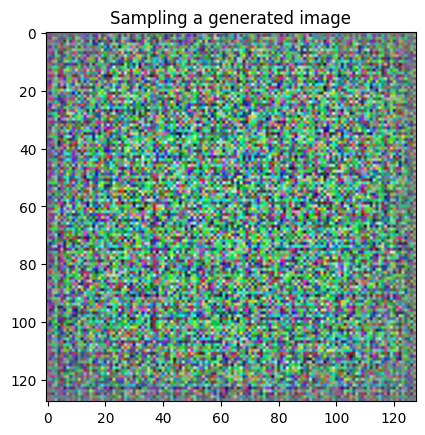

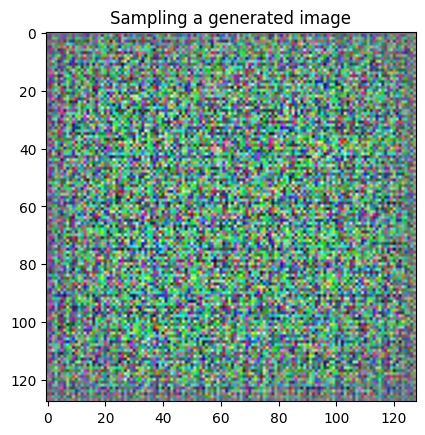

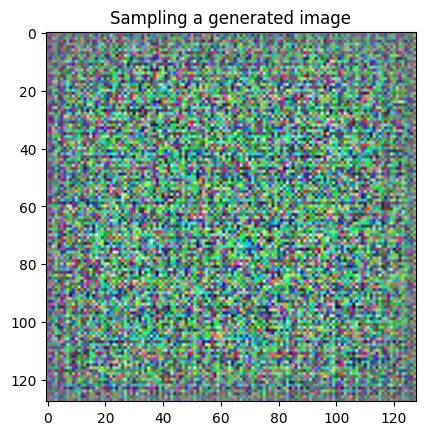

In [9]:
n_samples = 3

for i in range(n_samples):
    # Generate random noise
    noise = torch.randn(1, latent_dim, 1, 1)  # Batch of 16 noise vectors

    G_unet_test = G_unet.to('cpu')
    # Generate images
    fake_images = G_unet_test(noise)

    image_noise = fake_images.detach().numpy().reshape((3,128,128))*0.5 + 0.5

    plt.imshow(np.transpose(image_noise, (1, 2, 0)))
    plt.title("Sampling a generated image")
    plt.show()

<strong> Plotting losses </Strong>

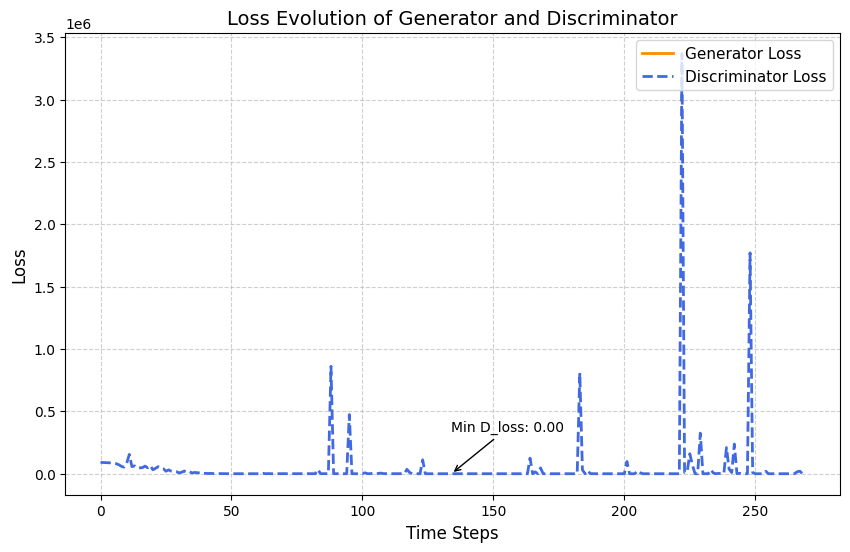

In [12]:
# Assuming G_loss and D_loss are defined
ng = len(G_loss)
nd = len(D_loss)
time_steps_g = [i for i in range(ng)]
time_steps_d = [i for i in range(nd)]


plt.figure(figsize=(10, 6))

# Plot Generator Loss
plt.plot(time_steps_g, G_loss, label='Generator Loss', color='darkorange', linestyle='-', linewidth=2)

# Plot Discriminator Loss
plt.plot(time_steps_d, D_loss, label='Discriminator Loss', color='royalblue', linestyle='--', linewidth=2)

# Add grid, labels, and title
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Evolution of Generator and Discriminator', fontsize=14)

# Adding legend
plt.legend(loc='upper right', fontsize=11)

# Adding annotations for minimum loss points (optional)
min_G_loss = min(G_loss)
min_G_loss_idx = G_loss.index(min_G_loss)
plt.annotate(f'Min G_loss: {min_G_loss:.2f}', xy=(min_G_loss_idx, min_G_loss),
             xytext=(min_G_loss_idx + n*0.1, min_G_loss + max(G_loss)*0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10)

min_D_loss = min(D_loss)
min_D_loss_idx = D_loss.index(min_D_loss)
plt.annotate(f'Min D_loss: {min_D_loss:.2f}', xy=(min_D_loss_idx, min_D_loss),
             xytext=(min_D_loss_idx + n*0.1, min_D_loss + max(D_loss)*0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10)

# Show plot
plt.show()

<strong> Plotting FID values </strong>

Text(0.5, 1.0, 'FID Evolution through training')

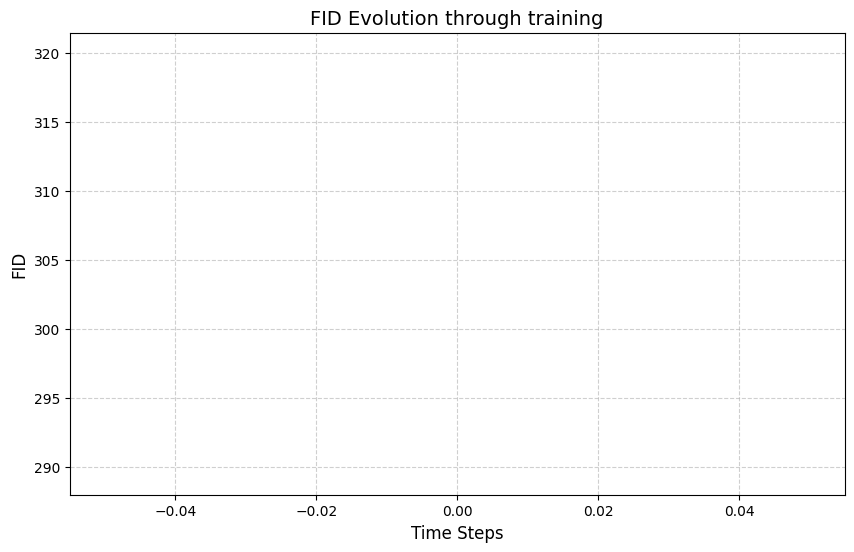

In [13]:
n = len(FID_values)
time_steps = [i for i in range(n)]

plt.figure(figsize=(10, 6))

# Plot FID values
plt.plot(time_steps, FID_values, label='Generator FID', color='darkorange', linestyle='-', linewidth=2)


# Add grid, labels, and title
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('FID', fontsize=12)
plt.title('FID Evolution through training', fontsize=14)